In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')
run_stats = {}

In [2]:
# parameters
dataset_name = ""
model_name = "resnet_edl_mse"
ood = ""
fpi = 10

In [3]:
# Parameters
dataset_name = "MNIST"
ood = ""


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data(shuffle_training_data=False)
config.print_labels()
dm = config.datamodule

assert dm

  0%|                                                                                                                                                       | 0/60000 [00:00<?, ?it/s]

 12%|████████████████▏                                                                                                                        | 7110/60000 [00:00<00:00, 71094.81it/s]

 24%|████████████████████████████████▏                                                                                                       | 14220/60000 [00:00<00:00, 69946.95it/s]

 35%|████████████████████████████████████████████████▏                                                                                       | 21273/60000 [00:00<00:00, 70205.93it/s]

 47%|████████████████████████████████████████████████████████████████▏                                                                       | 28295/60000 [00:00<00:00, 66376.48it/s]

 59%|███████████████████████████████████████████████████████████████████████████████▋                                                        | 35132/60000 [00:00<00:00, 67064.37it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 41860/60000 [00:00<00:00, 63402.24it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 48334/60000 [00:00<00:00, 63814.20it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 54747/60000 [00:00<00:00, 62380.79it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [00:00<00:00, 64733.17it/s]

  0%|                                                                                                                                                       | 0/10000 [00:00<?, ?it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████                                        | 7089/10000 [00:00<00:00, 70882.12it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 70231.41it/s]

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 kh2l9qec


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []
    trn_rcn_fpi = []
    trn_emb_fpi = []
    trn_lgt_fpi = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []
    val_rcn_fpi = []
    val_emb_fpi = []
    val_lgt_fpi = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []
    ind_rcn_fpi = []
    ind_emb_fpi = []
    ind_lgt_fpi = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []
        ood_rcn_fpi = []
        ood_emb_fpi = []
        ood_lgt_fpi = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []
    rnd_lgt = []
    rnd_rcn_fpi = []
    rnd_emb_fpi = []
    rnd_lgt_fpi = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        trn_rcn_fpi.extend(rcn.detach().cpu().numpy())
        trn_emb_fpi.extend(emb.detach().cpu().numpy())
        trn_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        val_rcn_fpi.extend(rcn.detach().cpu().numpy())
        val_emb_fpi.extend(emb.detach().cpu().numpy())
        val_lgt_fpi.extend(lgt.detach().cpu().numpy())
        
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        ind_rcn_fpi.extend(rcn.detach().cpu().numpy())
        ind_emb_fpi.extend(emb.detach().cpu().numpy())
        ind_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
            for _ in range(fpi):
                emb, lgt, rcn = model(rcn)
            ood_rcn_fpi.extend(rcn.detach().cpu().numpy())
            ood_emb_fpi.extend(emb.detach().cpu().numpy())
            ood_lgt_fpi.extend(lgt.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
        for i in range(fpi):
            emb, lgt, rcn = model(rcn)
        rnd_rcn_fpi.extend(rcn.detach().cpu().numpy())
        rnd_emb_fpi.extend(emb.detach().cpu().numpy())
        rnd_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                         | 0/375 [00:00<?, ?it/s]

  0%|▍                                                                                                                                                | 1/375 [00:01<06:39,  1.07s/it]

  1%|█▉                                                                                                                                               | 5/375 [00:01<01:07,  5.47it/s]

  2%|███▍                                                                                                                                             | 9/375 [00:01<00:35, 10.24it/s]

  3%|████▉                                                                                                                                           | 13/375 [00:01<00:24, 14.95it/s]

  5%|██████▌                                                                                                                                         | 17/375 [00:01<00:18, 19.33it/s]

  6%|████████                                                                                                                                        | 21/375 [00:01<00:15, 23.16it/s]

  7%|█████████▌                                                                                                                                      | 25/375 [00:01<00:13, 26.36it/s]

  8%|███████████▏                                                                                                                                    | 29/375 [00:01<00:11, 28.91it/s]

  9%|████████████▋                                                                                                                                   | 33/375 [00:01<00:11, 30.81it/s]

 10%|██████████████▏                                                                                                                                 | 37/375 [00:02<00:10, 32.33it/s]

 11%|███████████████▋                                                                                                                                | 41/375 [00:02<00:09, 33.42it/s]

 12%|█████████████████▎                                                                                                                              | 45/375 [00:02<00:09, 34.22it/s]

 13%|██████████████████▊                                                                                                                             | 49/375 [00:02<00:09, 34.75it/s]

 14%|████████████████████▎                                                                                                                           | 53/375 [00:02<00:09, 35.15it/s]

 15%|█████████████████████▉                                                                                                                          | 57/375 [00:02<00:08, 35.42it/s]

 16%|███████████████████████▍                                                                                                                        | 61/375 [00:02<00:08, 35.65it/s]

 17%|████████████████████████▉                                                                                                                       | 65/375 [00:02<00:08, 35.79it/s]

 18%|██████████████████████████▍                                                                                                                     | 69/375 [00:02<00:08, 35.93it/s]

 19%|████████████████████████████                                                                                                                    | 73/375 [00:03<00:08, 36.00it/s]

 21%|█████████████████████████████▌                                                                                                                  | 77/375 [00:03<00:08, 36.09it/s]

 22%|███████████████████████████████                                                                                                                 | 81/375 [00:03<00:08, 36.14it/s]

 23%|████████████████████████████████▋                                                                                                               | 85/375 [00:03<00:08, 36.17it/s]

 24%|██████████████████████████████████▏                                                                                                             | 89/375 [00:03<00:07, 36.07it/s]

 25%|███████████████████████████████████▋                                                                                                            | 93/375 [00:03<00:07, 36.12it/s]

 26%|█████████████████████████████████████▏                                                                                                          | 97/375 [00:03<00:07, 36.15it/s]

 27%|██████████████████████████████████████▌                                                                                                        | 101/375 [00:03<00:07, 36.19it/s]

 28%|████████████████████████████████████████                                                                                                       | 105/375 [00:03<00:07, 36.22it/s]

 29%|█████████████████████████████████████████▌                                                                                                     | 109/375 [00:04<00:07, 36.21it/s]

 30%|███████████████████████████████████████████                                                                                                    | 113/375 [00:04<00:07, 36.23it/s]

 31%|████████████████████████████████████████████▌                                                                                                  | 117/375 [00:04<00:07, 36.25it/s]

 32%|██████████████████████████████████████████████▏                                                                                                | 121/375 [00:04<00:07, 36.21it/s]

 33%|███████████████████████████████████████████████▋                                                                                               | 125/375 [00:04<00:06, 36.22it/s]

 34%|█████████████████████████████████████████████████▏                                                                                             | 129/375 [00:04<00:06, 36.23it/s]

 35%|██████████████████████████████████████████████████▋                                                                                            | 133/375 [00:04<00:06, 36.25it/s]

 37%|████████████████████████████████████████████████████▏                                                                                          | 137/375 [00:04<00:06, 36.22it/s]

 38%|█████████████████████████████████████████████████████▊                                                                                         | 141/375 [00:04<00:06, 36.18it/s]

 39%|███████████████████████████████████████████████████████▎                                                                                       | 145/375 [00:05<00:06, 36.20it/s]

 40%|████████████████████████████████████████████████████████▊                                                                                      | 149/375 [00:05<00:06, 36.21it/s]

 41%|██████████████████████████████████████████████████████████▎                                                                                    | 153/375 [00:05<00:06, 36.22it/s]

 42%|███████████████████████████████████████████████████████████▊                                                                                   | 157/375 [00:05<00:06, 36.21it/s]

 43%|█████████████████████████████████████████████████████████████▍                                                                                 | 161/375 [00:05<00:05, 36.20it/s]

 44%|██████████████████████████████████████████████████████████████▉                                                                                | 165/375 [00:05<00:05, 36.21it/s]

 45%|████████████████████████████████████████████████████████████████▍                                                                              | 169/375 [00:05<00:05, 36.20it/s]

 46%|█████████████████████████████████████████████████████████████████▉                                                                             | 173/375 [00:05<00:05, 36.20it/s]

 47%|███████████████████████████████████████████████████████████████████▍                                                                           | 177/375 [00:05<00:05, 36.19it/s]

 48%|█████████████████████████████████████████████████████████████████████                                                                          | 181/375 [00:06<00:05, 36.18it/s]

 49%|██████████████████████████████████████████████████████████████████████▌                                                                        | 185/375 [00:06<00:05, 36.17it/s]

 50%|████████████████████████████████████████████████████████████████████████                                                                       | 189/375 [00:06<00:05, 36.15it/s]

 51%|█████████████████████████████████████████████████████████████████████████▌                                                                     | 193/375 [00:06<00:05, 36.16it/s]

 53%|███████████████████████████████████████████████████████████████████████████                                                                    | 197/375 [00:06<00:04, 36.15it/s]

 54%|████████████████████████████████████████████████████████████████████████████▋                                                                  | 201/375 [00:06<00:04, 36.19it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▏                                                                | 205/375 [00:06<00:04, 36.20it/s]

 56%|███████████████████████████████████████████████████████████████████████████████▋                                                               | 209/375 [00:06<00:04, 36.22it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▏                                                             | 213/375 [00:06<00:04, 36.23it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████▋                                                            | 217/375 [00:07<00:04, 36.21it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▎                                                          | 221/375 [00:07<00:04, 36.17it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▊                                                         | 225/375 [00:07<00:04, 36.22it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▎                                                       | 229/375 [00:07<00:04, 36.24it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 233/375 [00:07<00:03, 36.24it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 237/375 [00:07<00:03, 36.24it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 241/375 [00:07<00:03, 36.25it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 245/375 [00:07<00:03, 36.24it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 249/375 [00:07<00:03, 36.19it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 253/375 [00:08<00:03, 36.23it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████                                             | 257/375 [00:08<00:03, 36.23it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 261/375 [00:08<00:03, 36.24it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 265/375 [00:08<00:03, 36.24it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 269/375 [00:08<00:02, 36.24it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 273/375 [00:08<00:02, 36.23it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 277/375 [00:08<00:02, 36.24it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 281/375 [00:08<00:02, 36.20it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 285/375 [00:08<00:02, 36.23it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 289/375 [00:09<00:02, 36.25it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 293/375 [00:09<00:02, 36.25it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 297/375 [00:09<00:02, 36.24it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 301/375 [00:09<00:02, 36.25it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 305/375 [00:09<00:01, 36.26it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 309/375 [00:09<00:01, 36.25it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 313/375 [00:09<00:01, 36.23it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 317/375 [00:09<00:01, 36.18it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 321/375 [00:09<00:01, 36.24it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 325/375 [00:10<00:01, 36.25it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 329/375 [00:10<00:01, 36.26it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 333/375 [00:10<00:01, 36.25it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 337/375 [00:10<00:01, 36.26it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 341/375 [00:10<00:00, 36.25it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 345/375 [00:10<00:00, 36.25it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 349/375 [00:10<00:00, 36.24it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 353/375 [00:10<00:00, 36.16it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 357/375 [00:10<00:00, 36.11it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 361/375 [00:11<00:00, 36.20it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 365/375 [00:11<00:00, 36.22it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 369/375 [00:11<00:00, 36.24it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 373/375 [00:11<00:00, 36.27it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:11<00:00, 32.85it/s]

train - OK


  0%|                                                                                                                                                          | 0/94 [00:00<?, ?it/s]

  1%|█▌                                                                                                                                                | 1/94 [00:00<00:12,  7.23it/s]

  5%|███████▊                                                                                                                                          | 5/94 [00:00<00:03, 22.52it/s]

 10%|█████████████▉                                                                                                                                    | 9/94 [00:00<00:02, 28.39it/s]

 14%|████████████████████                                                                                                                             | 13/94 [00:00<00:02, 31.37it/s]

 18%|██████████████████████████▏                                                                                                                      | 17/94 [00:00<00:02, 33.07it/s]

 22%|████████████████████████████████▍                                                                                                                | 21/94 [00:00<00:02, 34.14it/s]

 27%|██████████████████████████████████████▌                                                                                                          | 25/94 [00:00<00:01, 34.81it/s]

 31%|████████████████████████████████████████████▋                                                                                                    | 29/94 [00:00<00:01, 35.19it/s]

 35%|██████████████████████████████████████████████████▉                                                                                              | 33/94 [00:01<00:01, 35.51it/s]

 39%|█████████████████████████████████████████████████████████                                                                                        | 37/94 [00:01<00:01, 35.75it/s]

 44%|███████████████████████████████████████████████████████████████▏                                                                                 | 41/94 [00:01<00:01, 35.87it/s]

 48%|█████████████████████████████████████████████████████████████████████▍                                                                           | 45/94 [00:01<00:01, 35.95it/s]

 52%|███████████████████████████████████████████████████████████████████████████▌                                                                     | 49/94 [00:01<00:01, 36.03it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▊                                                               | 53/94 [00:01<00:01, 36.11it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▉                                                         | 57/94 [00:01<00:01, 36.15it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                   | 61/94 [00:01<00:00, 36.17it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 65/94 [00:01<00:00, 36.17it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 69/94 [00:02<00:00, 36.18it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 73/94 [00:02<00:00, 36.17it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 77/94 [00:02<00:00, 36.18it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 81/94 [00:02<00:00, 36.20it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 85/94 [00:02<00:00, 36.12it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 89/94 [00:02<00:00, 36.17it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 93/94 [00:02<00:00, 36.22it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:02<00:00, 33.77it/s]

val - OK


  0%|                                                                                                                                                          | 0/79 [00:00<?, ?it/s]

  1%|█▊                                                                                                                                                | 1/79 [00:00<00:10,  7.29it/s]

  6%|█████████▏                                                                                                                                        | 5/79 [00:00<00:03, 22.64it/s]

 11%|████████████████▋                                                                                                                                 | 9/79 [00:00<00:02, 28.48it/s]

 16%|███████████████████████▊                                                                                                                         | 13/79 [00:00<00:02, 31.42it/s]

 22%|███████████████████████████████▏                                                                                                                 | 17/79 [00:00<00:01, 33.07it/s]

 27%|██████████████████████████████████████▌                                                                                                          | 21/79 [00:00<00:01, 34.12it/s]

 32%|█████████████████████████████████████████████▉                                                                                                   | 25/79 [00:00<00:01, 34.78it/s]

 37%|█████████████████████████████████████████████████████▏                                                                                           | 29/79 [00:00<00:01, 35.22it/s]

 42%|████████████████████████████████████████████████████████████▌                                                                                    | 33/79 [00:01<00:01, 35.52it/s]

 47%|███████████████████████████████████████████████████████████████████▉                                                                             | 37/79 [00:01<00:01, 35.73it/s]

 52%|███████████████████████████████████████████████████████████████████████████▎                                                                     | 41/79 [00:01<00:01, 35.73it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▌                                                              | 45/79 [00:01<00:00, 35.86it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 49/79 [00:01<00:00, 35.95it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 53/79 [00:01<00:00, 36.03it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 57/79 [00:01<00:00, 36.07it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 61/79 [00:01<00:00, 36.11it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 65/79 [00:01<00:00, 36.12it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 69/79 [00:02<00:00, 36.14it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 73/79 [00:02<00:00, 36.14it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 77/79 [00:02<00:00, 36.18it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 32.12it/s]

test InD - OK


  0%|                                                                                                                                                         | 0/100 [00:00<?, ?it/s]

  4%|█████▊                                                                                                                                           | 4/100 [00:00<00:02, 37.15it/s]

  8%|███████████▌                                                                                                                                     | 8/100 [00:00<00:02, 37.13it/s]

 12%|█████████████████▎                                                                                                                              | 12/100 [00:00<00:02, 37.11it/s]

 16%|███████████████████████                                                                                                                         | 16/100 [00:00<00:02, 36.75it/s]

 20%|████████████████████████████▊                                                                                                                   | 20/100 [00:00<00:02, 36.54it/s]

 24%|██████████████████████████████████▌                                                                                                             | 24/100 [00:00<00:02, 36.43it/s]

 28%|████████████████████████████████████████▎                                                                                                       | 28/100 [00:00<00:01, 36.38it/s]

 32%|██████████████████████████████████████████████                                                                                                  | 32/100 [00:00<00:01, 36.35it/s]

 36%|███████████████████████████████████████████████████▊                                                                                            | 36/100 [00:00<00:01, 36.34it/s]

 40%|█████████████████████████████████████████████████████████▌                                                                                      | 40/100 [00:01<00:01, 36.32it/s]

 44%|███████████████████████████████████████████████████████████████▎                                                                                | 44/100 [00:01<00:01, 36.31it/s]

 48%|█████████████████████████████████████████████████████████████████████                                                                           | 48/100 [00:01<00:01, 36.32it/s]

 52%|██████████████████████████████████████████████████████████████████████████▉                                                                     | 52/100 [00:01<00:01, 36.31it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▋                                                               | 56/100 [00:01<00:01, 36.29it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▍                                                         | 60/100 [00:01<00:01, 36.31it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 64/100 [00:01<00:00, 36.29it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 68/100 [00:01<00:00, 36.30it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 72/100 [00:01<00:00, 36.31it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 76/100 [00:02<00:00, 36.24it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 80/100 [00:02<00:00, 36.26it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 84/100 [00:02<00:00, 36.22it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 88/100 [00:02<00:00, 36.25it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 92/100 [00:02<00:00, 36.27it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 96/100 [00:02<00:00, 36.27it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 36.29it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 36.36it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)
trn_rcn_fpi = np.array(trn_rcn_fpi)
trn_emb_fpi = np.array(trn_emb_fpi).squeeze()
trn_lgt_fpi = np.array(trn_lgt_fpi).squeeze()

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)
val_rcn_fpi = np.array(val_rcn_fpi)
val_emb_fpi = np.array(val_emb_fpi).squeeze()
val_lgt_fpi = np.array(val_lgt_fpi).squeeze()

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)
ind_rcn_fpi = np.array(ind_rcn_fpi)
ind_emb_fpi = np.array(ind_emb_fpi).squeeze()
ind_lgt_fpi = np.array(ind_lgt_fpi).squeeze()

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)
    ood_rcn_fpi = np.array(ood_rcn_fpi)
    ood_emb_fpi = np.array(ood_emb_fpi).squeeze()
    ood_lgt_fpi = np.array(ood_lgt_fpi).squeeze()

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()
rnd_rcn_fpi = np.array(rnd_rcn_fpi)
rnd_emb_fpi = np.array(rnd_emb_fpi).squeeze()
rnd_lgt_fpi = np.array(rnd_lgt_fpi).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(48000, 1, 32, 32) (48000, 1, 32, 32) (48000, 256) (48000, 10) (48000,)
(12000, 1, 32, 32) (12000, 1, 32, 32) (12000, 256) (12000, 10) (12000,)
(10000, 1, 32, 32) (10000, 1, 32, 32) (10000, 256) (10000, 10) (10000,)
(12800, 1, 32, 32) (12800, 1, 32, 32) (12800, 256) (12800, 10)


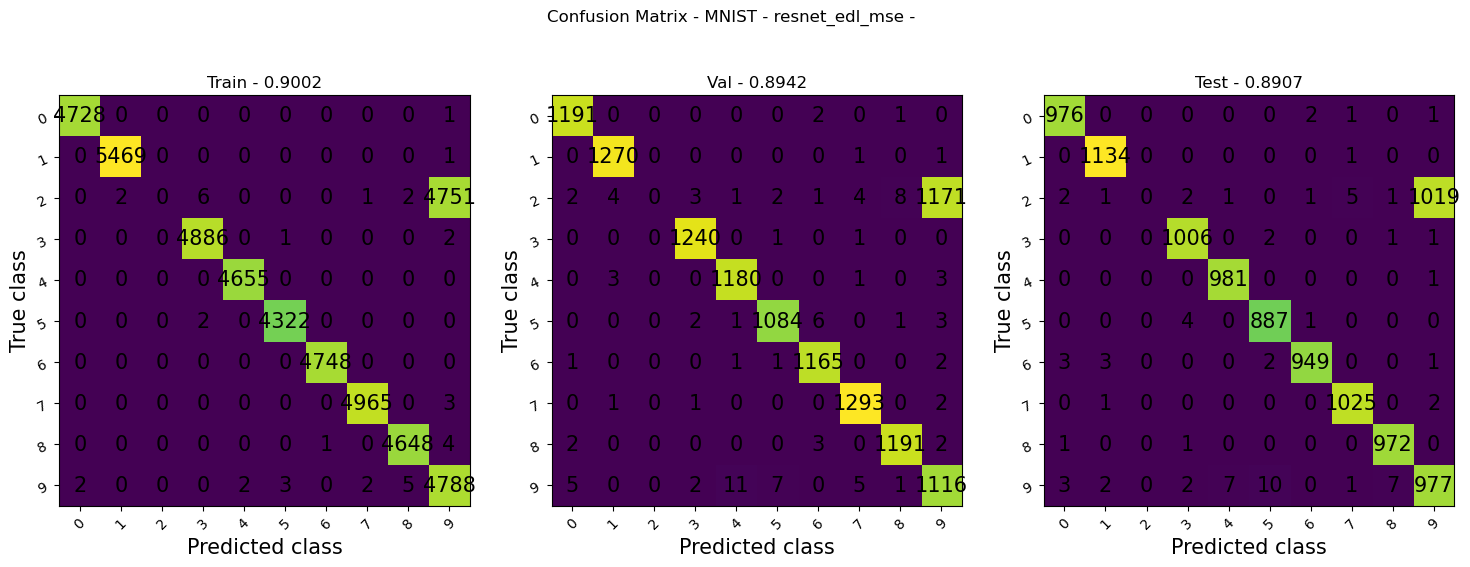

In [11]:
# compute test set accuracy
from torchmetrics import Accuracy, ConfusionMatrix

K = len(config.labels) - len(config.ood)
accuracy = Accuracy(task="multiclass", num_classes=K, top_k=1)

train_acc = accuracy(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt)).item()
accuracy.reset()
val_acc = accuracy(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt)).item()
accuracy.reset()
test_acc = accuracy(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt)).item()
run_stats.update(dict(train_acc=train_acc, val_acc=val_acc, test_acc=test_acc))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
confmat = ConfusionMatrix(task="multiclass", num_classes=K)
cm_trn = confmat(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax1)
ax1.set_title(f"Train - {train_acc:.4f}")
confmat.reset()
cm_val = confmat(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax2)
ax2.set_title(f"Val - {val_acc:.4f}")
confmat.reset()
cm_tst = confmat(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax3)
ax3.set_title(f"Test - {test_acc:.4f}")

plt.suptitle(f"Confusion Matrix - {dataset_name} - {model_name} - {ood_str}")
plt.show()

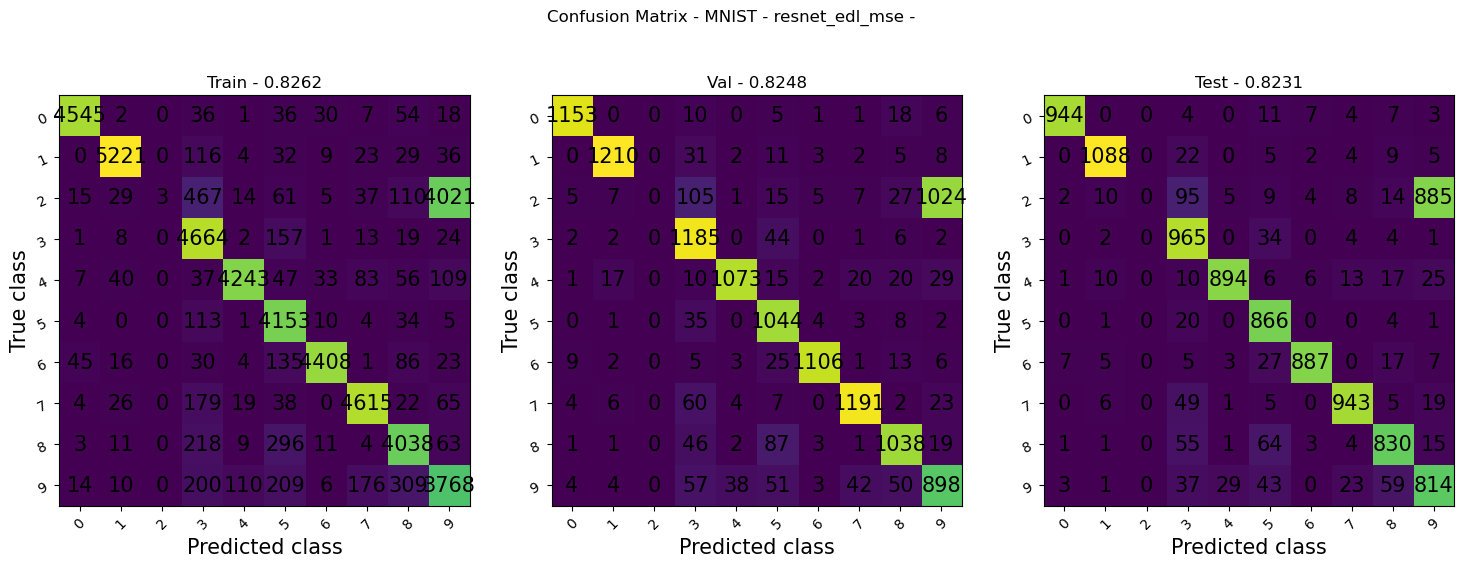

In [12]:
# compute test set accuracy - FPI
from torchmetrics import Accuracy, ConfusionMatrix

K = len(config.labels) - len(config.ood)
accuracy = Accuracy(task="multiclass", num_classes=K, top_k=1)

train_acc = accuracy(torch.as_tensor(trn_lgt_fpi.argmax(-1)), torch.as_tensor(trn_tgt)).item()
accuracy.reset()
val_acc = accuracy(torch.as_tensor(val_lgt_fpi.argmax(-1)), torch.as_tensor(val_tgt)).item()
accuracy.reset()
test_acc = accuracy(torch.as_tensor(ind_lgt_fpi.argmax(-1)), torch.as_tensor(ind_tgt)).item()
run_stats.update(dict(ftrain_acc=train_acc, fval_acc=val_acc, ftest_acc=test_acc))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
confmat = ConfusionMatrix(task="multiclass", num_classes=K)
cm_trn = confmat(torch.as_tensor(trn_lgt_fpi.argmax(-1)), torch.as_tensor(trn_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax1)
ax1.set_title(f"Train - {train_acc:.4f}")
confmat.reset()
cm_val = confmat(torch.as_tensor(val_lgt_fpi.argmax(-1)), torch.as_tensor(val_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax2)
ax2.set_title(f"Val - {val_acc:.4f}")
confmat.reset()
cm_tst = confmat(torch.as_tensor(ind_lgt_fpi.argmax(-1)), torch.as_tensor(ind_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax3)
ax3.set_title(f"Test - {test_acc:.4f}")

plt.suptitle(f"Confusion Matrix - {dataset_name} - {model_name} - {ood_str}")
plt.show()

In [13]:
# create 2d embeddings
n = ind_emb.shape[0]
all_emb = ind_emb
all_lgt = ind_lgt
if ood_str:
    all_emb = np.concatenate([all_emb, ood_emb], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_emb2d = umap.fit_transform(all_emb)
ind_emb2d = np.array(all_emb2d[:n], order='C').astype(np.float32)
ood_emb2d = np.array(all_emb2d[n:], order='C').astype(np.float32)
print(ind_emb2d.shape, ood_emb2d.shape)

if all_lgt.shape[-1] > 2:
    umap = UMAP(n_components=2, random_state=42)
    lgt2d = umap.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(10000, 2) (0, 2)


/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(10000, 2) (0, 2)


In [14]:
# create 2d embeddings - FPI
n = ind_emb_fpi.shape[0]
all_emb_fpi = ind_emb_fpi
all_lgt_fpi = ind_lgt_fpi
if ood_str:
    all_emb_fpi = np.concatenate([all_emb_fpi, ood_emb_fpi], axis=0)
    all_lgt_fpi = np.concatenate([all_lgt_fpi, ood_lgt_fpi], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_emb_fpi2d = umap.fit_transform(all_emb_fpi)
ind_emb_fpi2d = np.array(all_emb_fpi2d[:n], order='C').astype(np.float32)
ood_emb_fpi2d = np.array(all_emb_fpi2d[n:], order='C').astype(np.float32)
print(ind_emb_fpi2d.shape, ood_emb_fpi2d.shape)

if all_lgt_fpi.shape[-1] > 2:
    umap = UMAP(n_components=2, random_state=42)
    all_lgt_fpi2d = umap.fit_transform(all_lgt_fpi)
else:
    all_lgt_fpi2d = all_lgt_fpi
ind_lgt_fpi2d = np.array(all_lgt_fpi2d[:n], order='C').astype(np.float32)
ood_lgt_fpi2d = np.array(all_lgt_fpi2d[n:], order='C').astype(np.float32)
print(ind_lgt_fpi2d.shape, ood_lgt_fpi2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(10000, 2) (0, 2)


/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(10000, 2) (0, 2)


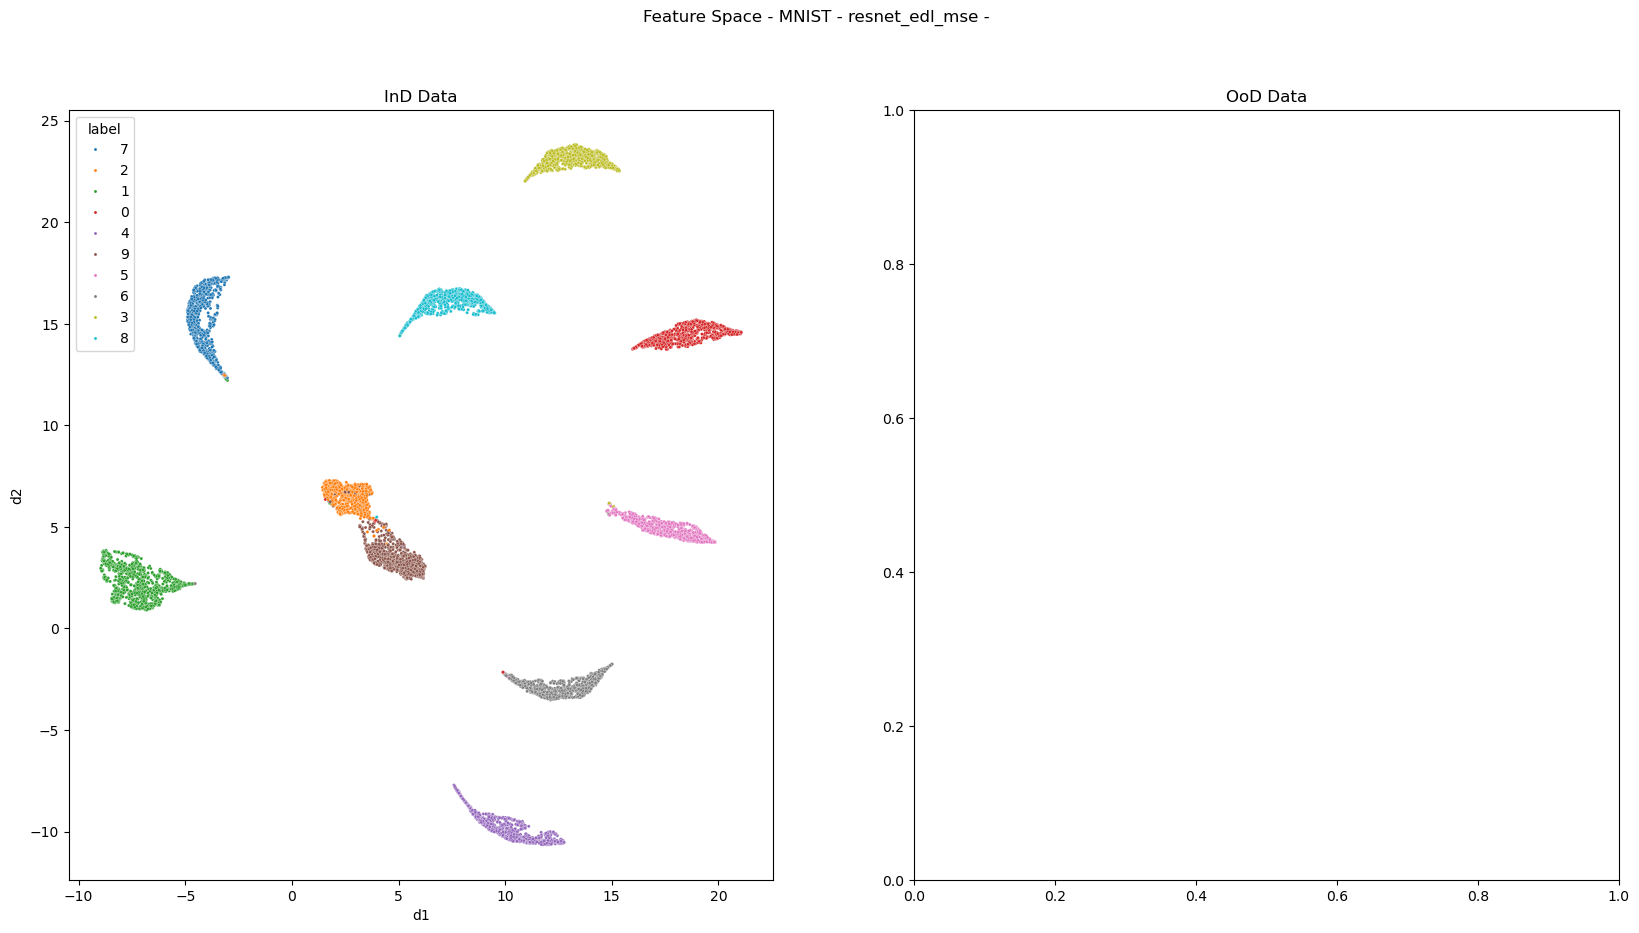

In [15]:
# plot feature space
df_emb2d = pd.DataFrame()
d1, d2 = ind_emb2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

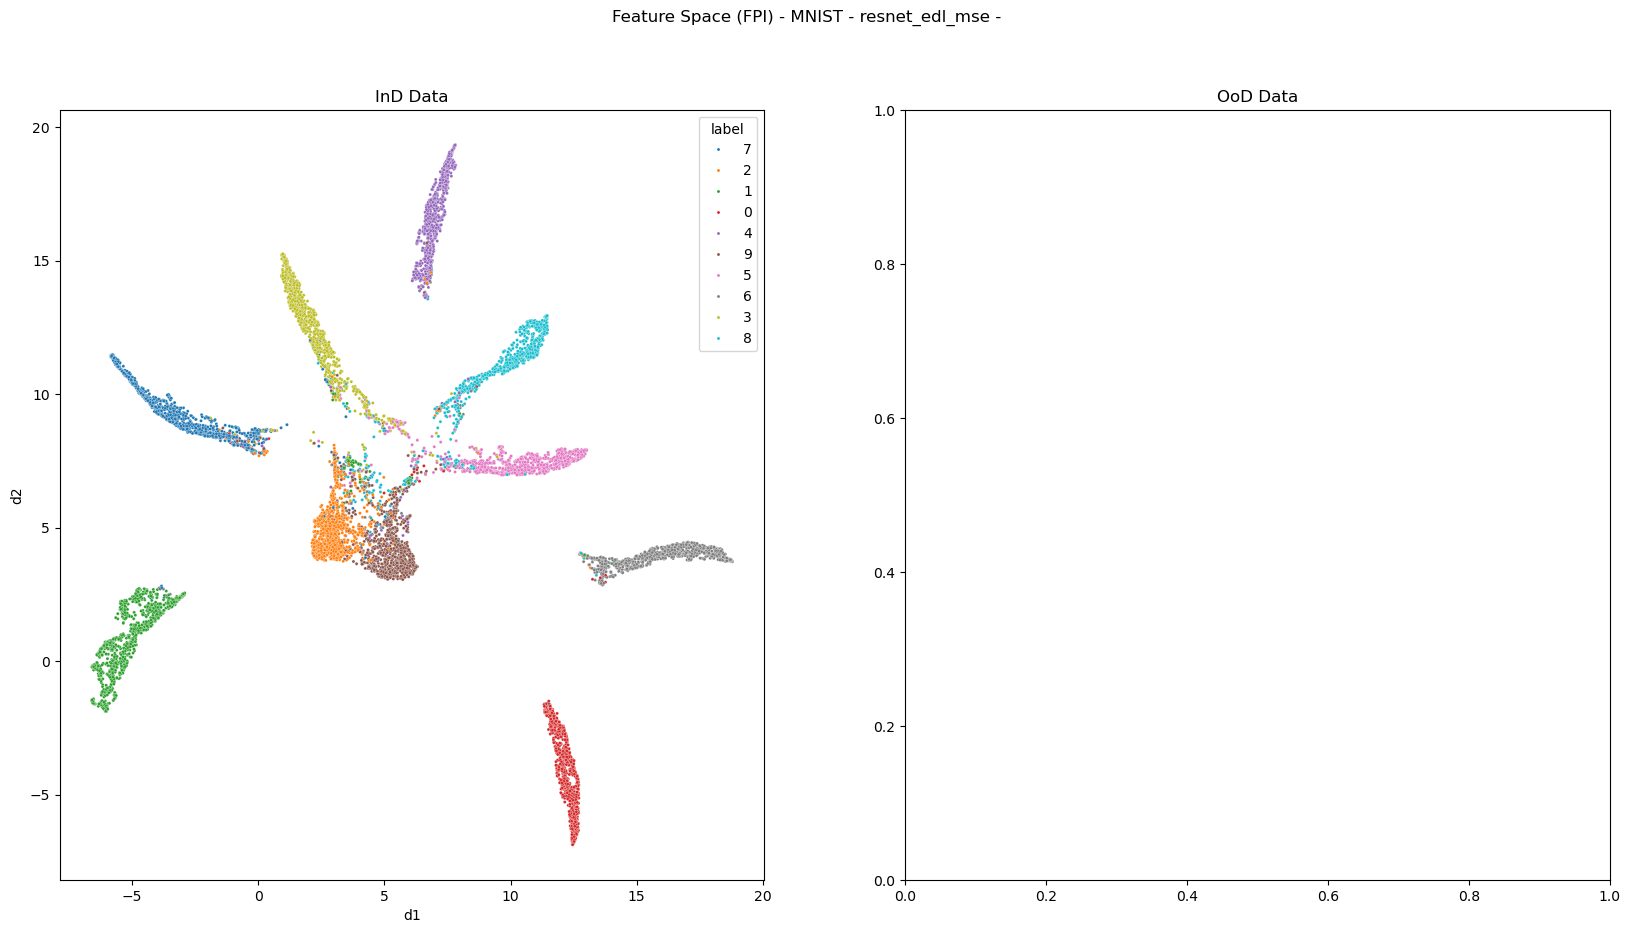

In [16]:
# plot feature space - FPI
df_emb_fpi2d = pd.DataFrame()
d1, d2 = ind_emb_fpi2d.T
df_emb_fpi2d = pd.concat([df_emb_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb_fpi2d.T
    df_emb_fpi2d = pd.concat([df_emb_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space (FPI) - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb_fpi2d[(df_emb_fpi2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb_fpi2d[(df_emb_fpi2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

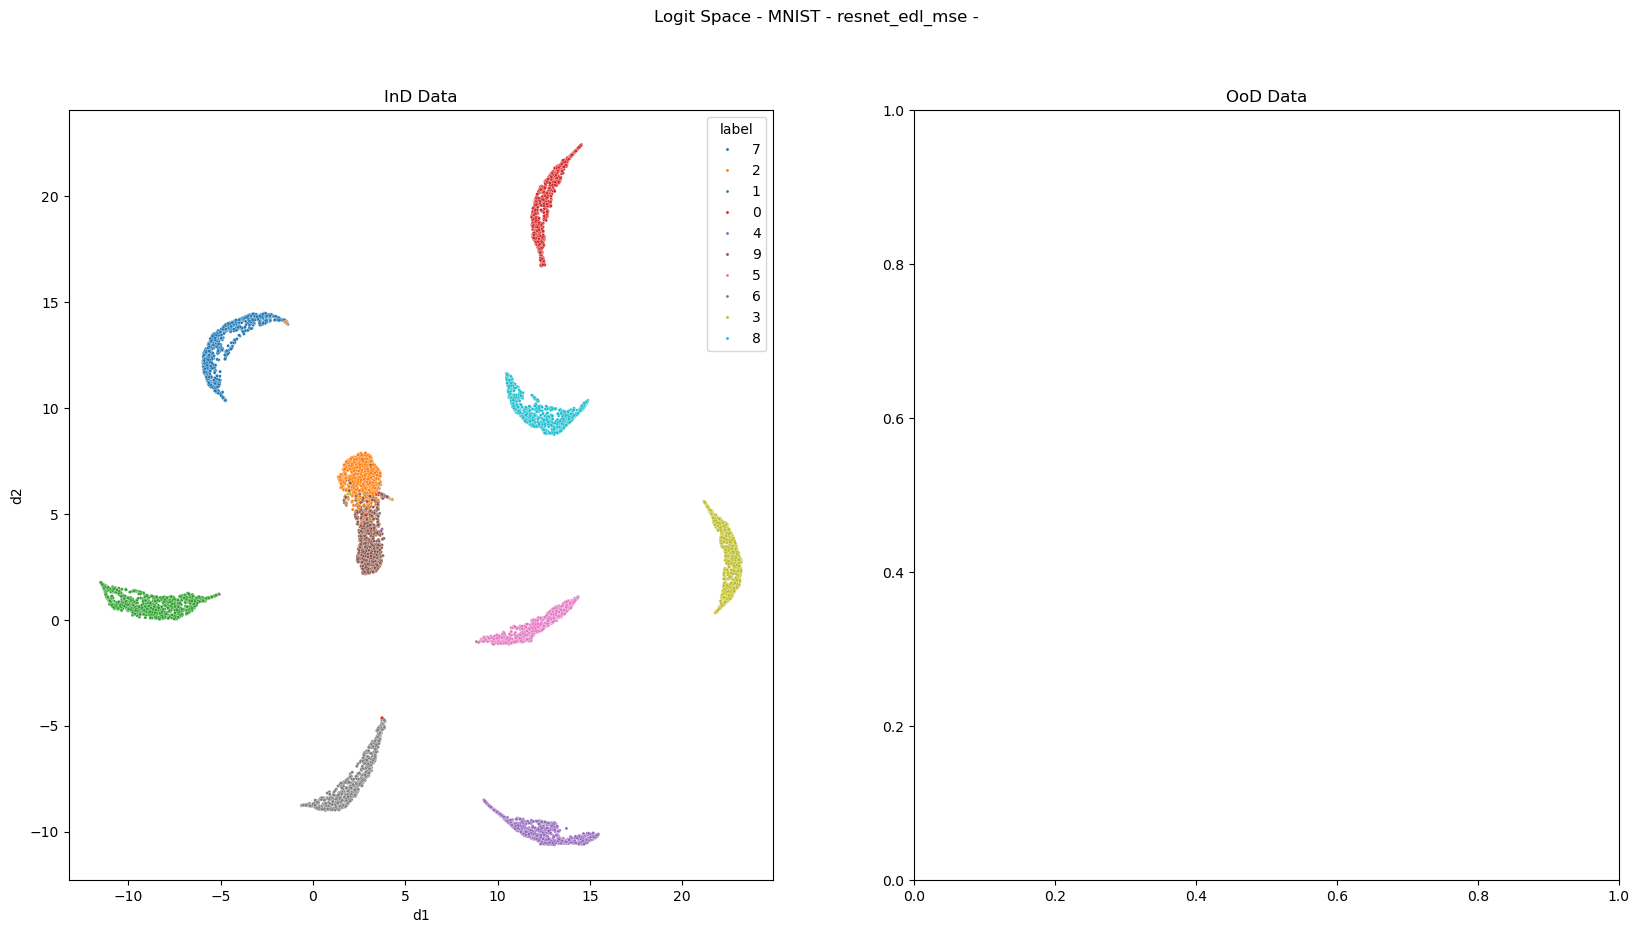

In [17]:
# plot logit space
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

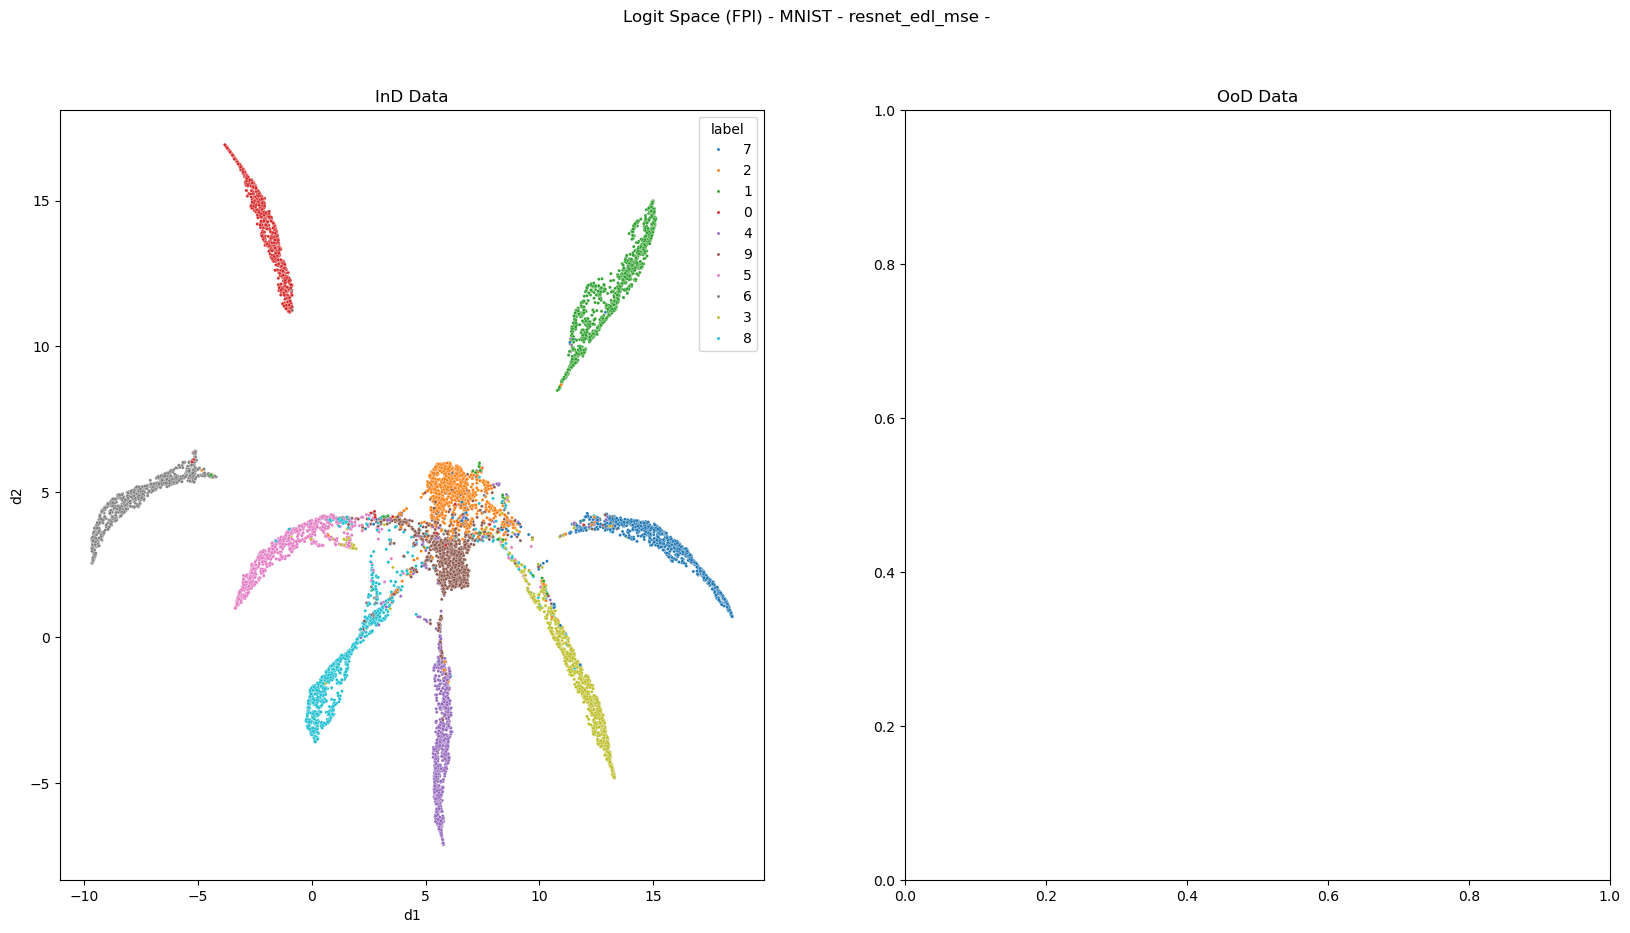

In [18]:
# plot logit space - FPI
df_lgt_fpi2d = pd.DataFrame()
d1, d2 = ind_lgt_fpi2d.T
df_lgt_fpi2d = pd.concat([df_lgt_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt_fpi2d.T
    df_lgt_fpi2d = pd.concat([df_lgt_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space (FPI) - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt_fpi2d[(df_lgt_fpi2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt_fpi2d[(df_lgt_fpi2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

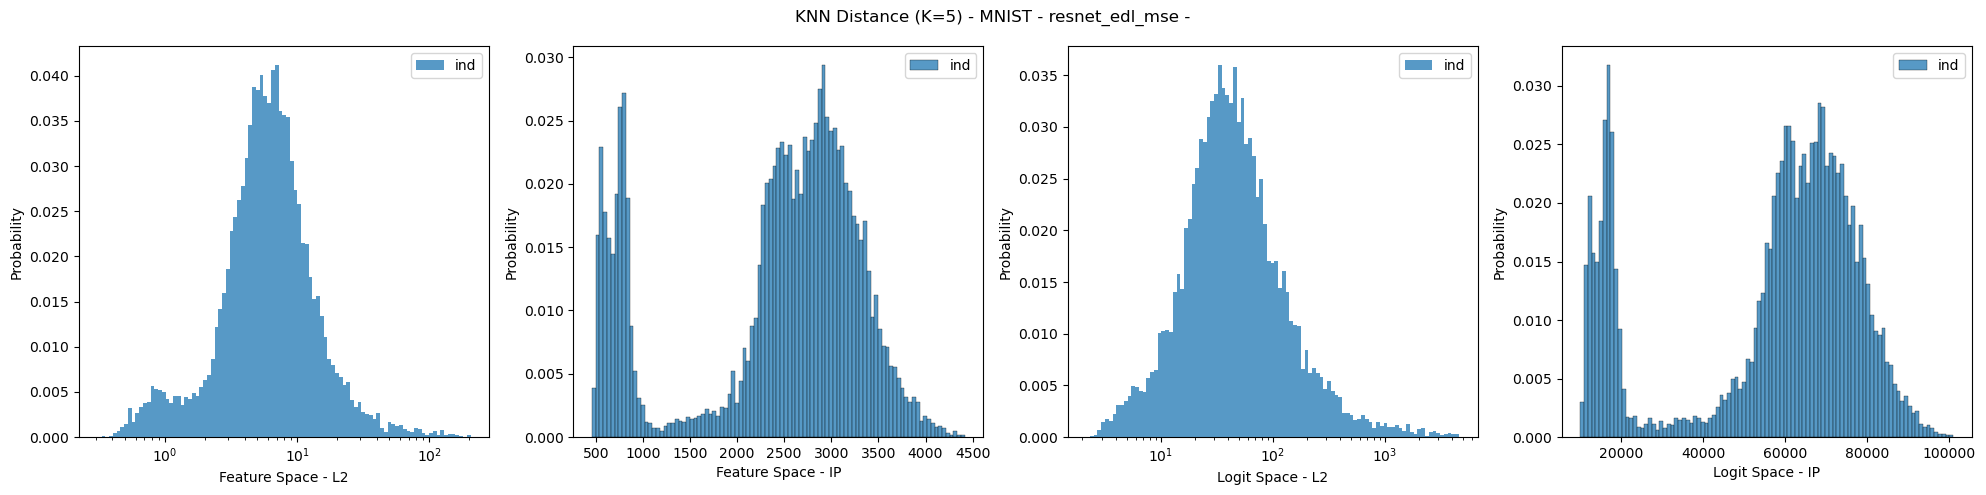

In [19]:
# plot knn distance from ind/ood to val data
def plot_knn_dists(index_fn, ax, trn_data, val_data, ind_data, ood_data=None, k=5, scale="linspace"):
    stats = {}
    index = index_fn(trn_data.shape[-1])
    index.add(trn_data)
    Dv = index.search(val_data, k)[0].mean(-1)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=Dv.tolist(), ind_data=Di.tolist(), ood_data=Do.tolist()))
        
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()
    return stats


fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")
run_stats["knn_f_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0], trn_emb, val_emb, ind_emb, ood_emb if ood_str else None, scale="logspace")
axs[0].set_xlabel("Feature Space - L2")
run_stats["knn_f_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1], trn_emb, val_emb, ind_emb, ood_emb if ood_str else None, scale="linspace")
axs[1].set_xlabel("Feature Space - IP")
run_stats["knn_l_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[2], trn_lgt, val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="logspace")
axs[2].set_xlabel("Logit Space - L2")
run_stats["knn_l_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[3], trn_lgt, val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="linspace")
axs[3].set_xlabel("Logit Space - IP")
plt.tight_layout()
plt.show()

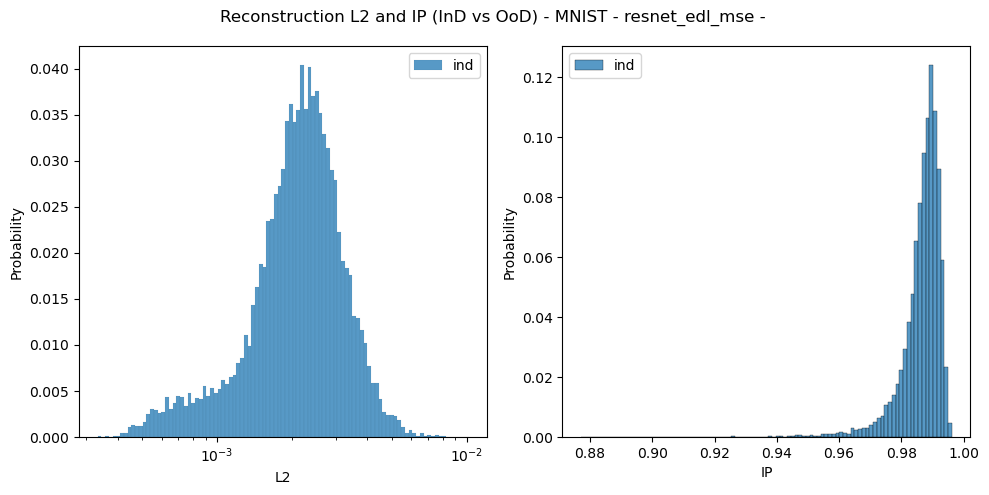

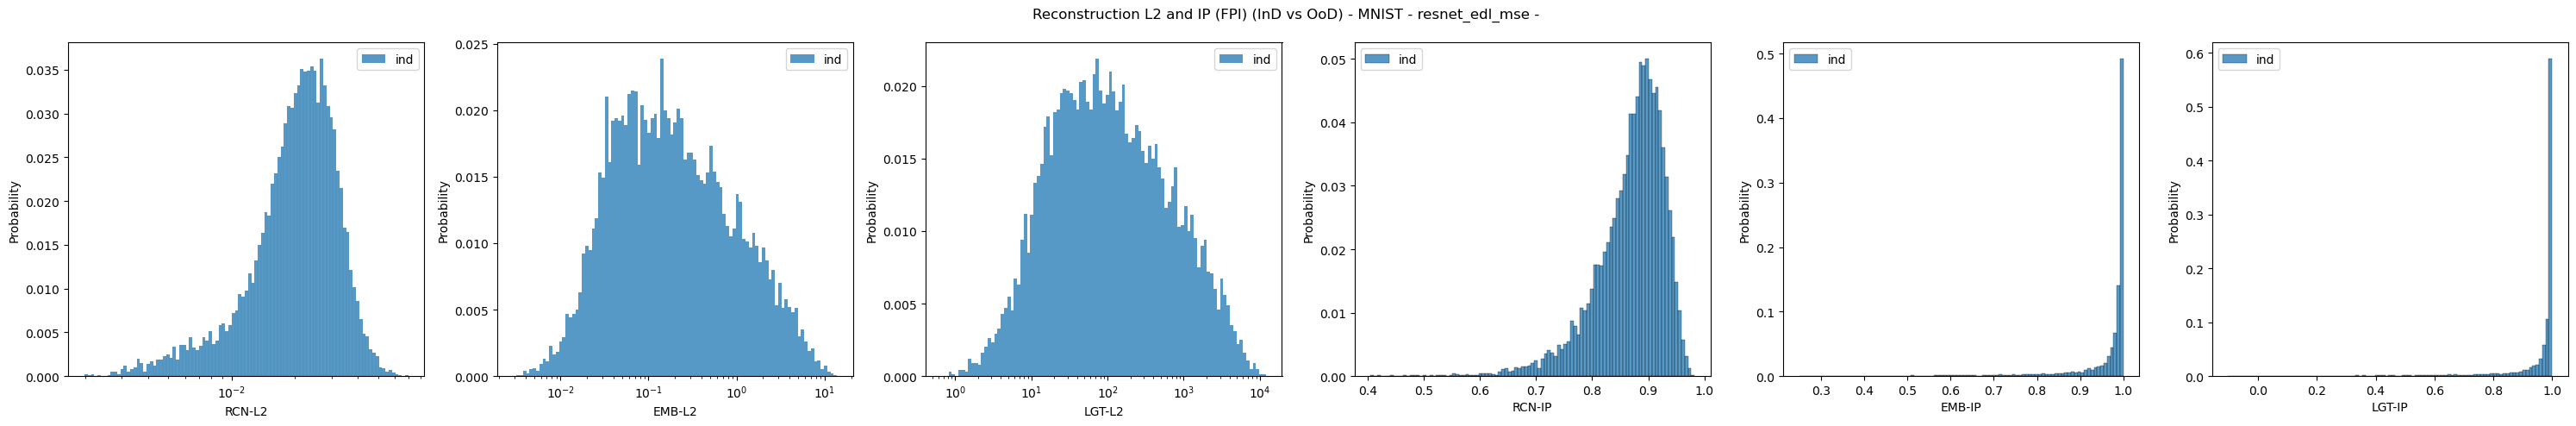

In [20]:
# plot reconstruction-based ood metrics
def plot_rcn(val_rcn, ind_rcn, ood_rcn, ax, scale="linspace"):
    stats = {}
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=val_rcn.tolist(), ind_data=ind_rcn.tolist(), ood_data=ood_rcn.tolist()))
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()
    return stats

flatten = lambda x: x.reshape((x.shape[0], -1))
unit = lambda x: x / (np.linalg.norm(x, axis=-1, keepdims=True) + 1e-7)

# validation data
_val_inp = flatten(val_inp)
_val_rcn, _val_emb, _val_lgt = flatten(val_rcn), flatten(val_emb), flatten(val_lgt)
_val_rcn_fpi, _val_emb_fpi, _val_lgt_fpi = flatten(val_rcn_fpi), flatten(val_emb_fpi), flatten(val_lgt_fpi)
_val_inp_unit = unit(_val_inp)
_val_rcn_unit, _val_emb_unit, _val_lgt_unit = unit(_val_rcn), unit(_val_emb), unit(_val_lgt)
_val_rcn_fpi_unit, _val_emb_fpi_unit, _val_lgt_fpi_unit = unit(_val_rcn_fpi), unit(_val_emb_fpi), unit(_val_lgt_fpi)
# metrics
val_rcn_l2 = ((_val_inp - _val_rcn) ** 2).mean(-1)
val_rcn_ip = (_val_inp_unit * _val_rcn_unit).sum(-1)
val_rcn_l2_fpi = ((_val_inp - _val_rcn_fpi) ** 2).mean(-1)
val_emb_l2_fpi = ((_val_emb - _val_emb_fpi) ** 2).mean(-1)
val_lgt_l2_fpi = ((_val_lgt - _val_lgt_fpi) ** 2).mean(-1)
val_rcn_ip_fpi = (_val_inp_unit * _val_rcn_fpi_unit).sum(-1)
val_emb_ip_fpi = (_val_emb_unit * _val_emb_fpi_unit).sum(-1)
val_lgt_ip_fpi = (_val_lgt_unit * _val_lgt_fpi_unit).sum(-1)

# ind test data
_ind_inp = flatten(ind_inp)
_ind_rcn, _ind_emb, _ind_lgt = flatten(ind_rcn), flatten(ind_emb), flatten(ind_lgt)
_ind_rcn_fpi, _ind_emb_fpi, _ind_lgt_fpi = flatten(ind_rcn_fpi), flatten(ind_emb_fpi), flatten(ind_lgt_fpi)
_ind_inp_unit = unit(_ind_inp)
_ind_rcn_unit, _ind_emb_unit, _ind_lgt_unit = unit(_ind_rcn), unit(_ind_emb), unit(_ind_lgt)
_ind_rcn_fpi_unit, _ind_emb_fpi_unit, _ind_lgt_fpi_unit = unit(_ind_rcn_fpi), unit(_ind_emb_fpi), unit(_ind_lgt_fpi)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)
ind_rcn_l2_fpi = ((_ind_inp - _ind_rcn_fpi) ** 2).mean(-1)
ind_emb_l2_fpi = ((_ind_emb - _ind_emb_fpi) ** 2).mean(-1)
ind_lgt_l2_fpi = ((_ind_lgt - _ind_lgt_fpi) ** 2).mean(-1)
ind_rcn_ip_fpi = (_ind_inp_unit * _ind_rcn_fpi_unit).sum(-1)
ind_emb_ip_fpi = (_ind_emb_unit * _ind_emb_fpi_unit).sum(-1)
ind_lgt_ip_fpi = (_ind_lgt_unit * _ind_lgt_fpi_unit).sum(-1)

if ood_str:
    # ood test data    
    _ood_inp = flatten(ood_inp)
    _ood_rcn, _ood_emb, _ood_lgt = flatten(ood_rcn), flatten(ood_emb), flatten(ood_lgt)
    _ood_rcn_fpi, _ood_emb_fpi, _ood_lgt_fpi = flatten(ood_rcn_fpi), flatten(ood_emb_fpi), flatten(ood_lgt_fpi)
    _ood_inp_unit = unit(_ood_inp)
    _ood_rcn_unit, _ood_emb_unit, _ood_lgt_unit = unit(_ood_rcn), unit(_ood_emb), unit(_ood_lgt)
    _ood_rcn_fpi_unit, _ood_emb_fpi_unit, _ood_lgt_fpi_unit = unit(_ood_rcn_fpi), unit(_ood_emb_fpi), unit(_ood_lgt_fpi)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)
    ood_rcn_l2_fpi = ((_ood_inp - _ood_rcn_fpi) ** 2).mean(-1)
    ood_emb_l2_fpi = ((_ood_emb - _ood_emb_fpi) ** 2).mean(-1)
    ood_lgt_l2_fpi = ((_ood_lgt - _ood_lgt_fpi) ** 2).mean(-1)
    ood_rcn_ip_fpi = (_ood_inp_unit * _ood_rcn_fpi_unit).sum(-1)
    ood_emb_ip_fpi = (_ood_emb_unit * _ood_emb_fpi_unit).sum(-1)
    ood_lgt_ip_fpi = (_ood_lgt_unit * _ood_lgt_fpi_unit).sum(-1)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
run_stats["rcn_l2"] = plot_rcn(val_rcn_l2, ind_rcn_l2, ood_rcn_l2 if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("L2")
run_stats["rcn_ip"] = plot_rcn(val_rcn_ip, ind_rcn_ip, ood_rcn_ip if ood_str else None, ax2, scale="linspace")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()


fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=1, ncols=6, figsize=(30, 5))
run_stats["frcn_l2"] = plot_rcn(val_rcn_l2_fpi, ind_rcn_l2_fpi, ood_rcn_l2_fpi if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("RCN-L2")
run_stats["femb_l2"] = plot_rcn(val_emb_l2_fpi, ind_emb_l2_fpi, ood_emb_l2_fpi if ood_str else None, ax2, scale="logspace")
ax2.set_xlabel("EMB-L2")
run_stats["flgt_l2"] = plot_rcn(val_lgt_l2_fpi, ind_lgt_l2_fpi, ood_lgt_l2_fpi if ood_str else None, ax3, scale="logspace")
ax3.set_xlabel("LGT-L2")
run_stats["frcn_ip"] = plot_rcn(val_rcn_ip_fpi, ind_rcn_ip_fpi, ood_rcn_ip_fpi if ood_str else None, ax4, scale="linspace")
ax4.set_xlabel("RCN-IP")
run_stats["femb_ip"] = plot_rcn(val_emb_ip_fpi, ind_emb_ip_fpi, ood_emb_ip_fpi if ood_str else None, ax5, scale="linspace")
ax5.set_xlabel("EMB-IP")
run_stats["flgt_ip"] = plot_rcn(val_lgt_ip_fpi, ind_lgt_ip_fpi, ood_lgt_ip_fpi if ood_str else None, ax6, scale="linspace")
ax6.set_xlabel("LGT-IP")
plt.suptitle(f"Reconstruction L2 and IP (FPI) (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

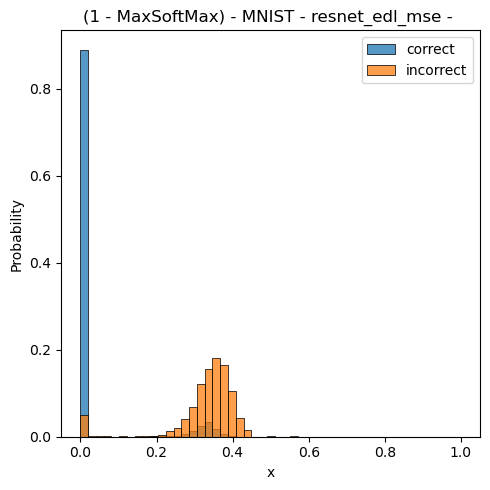

In [21]:
# plot (1 - maxsoftmax) of correct-ind, incorrect-ind, and ood data
ind_prob = np.exp(ind_lgt.astype(np.float64)) / np.exp(ind_lgt.astype(np.float64)).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt.astype(np.float64)) / np.exp(ood_lgt.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

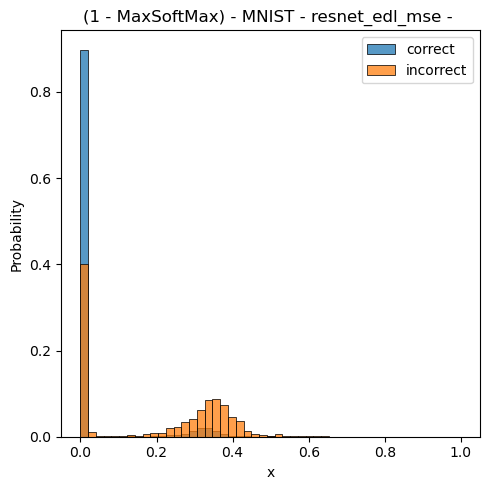

In [22]:
# plot (1 - maxsoftmax) distribution - FPI
ind_prob_fpi = np.exp(ind_lgt_fpi.astype(np.float64)) / np.exp(ind_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
ind_pred_fpi = ind_prob_fpi.argmax(-1)
ind_ucty_fpi = -ind_prob_fpi.max(-1) + 1.0

if ood_str:
    ood_prob_fpi = np.exp(ood_lgt_fpi.astype(np.float64)) / np.exp(ood_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred_fpi = ood_prob_fpi.argmax(-1)
    ood_ucty_fpi = -ood_prob_fpi.max(-1) + 1.0

df_t_fpi = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi == ind_tgt]}).copy()
df_f_fpi = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi != ind_tgt]}).copy()
df_fpi = pd.concat([df_t_fpi, df_f_fpi], ignore_index=True)
if ood_str:
    df_o_fpi = pd.DataFrame({"x": ood_ucty_fpi}).copy()
    df_fpi = pd.concat([df_fpi, df_o_fpi], ignore_index=True)
df_fpi_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t_fpi, x="x", label="correct", stat="probability", bins=df_fpi_bins, ax=ax)
sns.histplot(df_f_fpi, x="x", label="incorrect", stat="probability", bins=df_fpi_bins, ax=ax)
if ood_str:
    sns.histplot(df_o_fpi, x="x", label="ood", stat="probability", bins=df_fpi_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

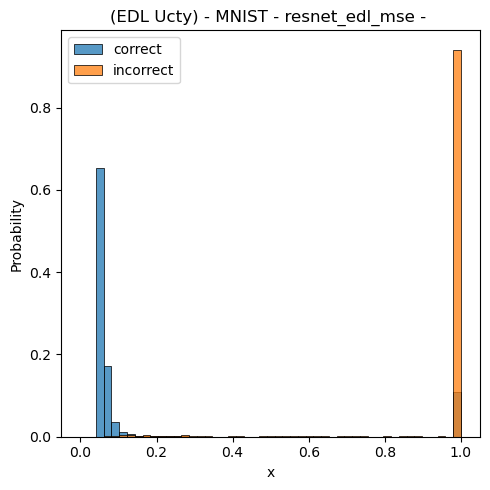

In [23]:
# plot (EDL uncertainty) of correct-ind, incorrect-ind, and ood data
K = ind_lgt.shape[-1]
ind_belief = np.clip(ind_lgt, 0, None)
ind_pred = ind_lgt.argmax(-1)
ind_prob = ind_belief / (ind_belief.sum(-1, keepdims=True) + K)
ind_ucty = K / (ind_belief.sum(-1) + K)

if ood_str:
    ood_belief = np.clip(ood_lgt, 0, None)
    ood_pred = ood_lgt.argmax(-1)
    ood_prob = ood_belief / (ood_belief.sum(-1, keepdims=True) + K)
    ood_ucty = K / (ood_belief.sum(-1) + K)

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(EDL Ucty) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

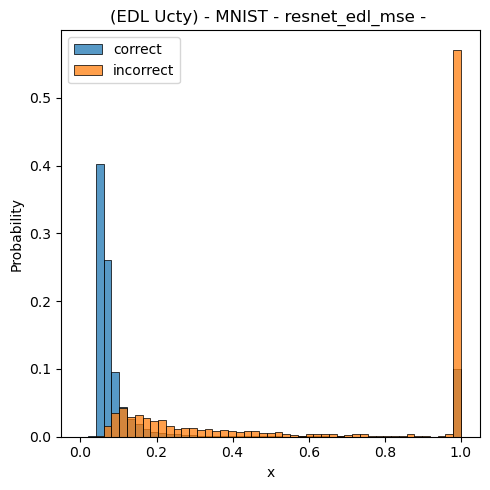

In [24]:
# plot (EDL uncertainty) of correct-ind, incorrect-ind, and ood data - FPI
K = ind_lgt_fpi.shape[-1]
ind_belief_fpi = np.clip(ind_lgt_fpi, 0, None)
ind_pred_fpi = ind_lgt_fpi.argmax(-1)
ind_prob_fpi = ind_belief_fpi / (ind_belief_fpi.sum(-1, keepdims=True) + K)
ind_ucty_fpi = K / (ind_belief_fpi.sum(-1) + K)

if ood_str:
    ood_belief_fpi = np.clip(ood_lgt_fpi, 0, None)
    ood_pred_fpi = ood_lgt_fpi.argmax(-1)
    ood_prob_fpi = ood_belief_fpi / (ood_belief_fpi.sum(-1, keepdims=True) + K)
    ood_ucty_fpi = K / (ood_belief_fpi.sum(-1) + K)

df_t = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty_fpi}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(EDL Ucty) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [25]:
run_stats.update(dict(dataset_name=dataset_name, model_name=model_name, ood=ood))

import json
from datetime import datetime
with open(f"assets/results/{datetime.now()}.json", "w") as f:
    json.dump(run_stats, f)